<a href="https://colab.research.google.com/github/lindatey/melanoma_detector_with_cnn/blob/main/Assignment_CNN_Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array

!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-z83tmw1v
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-z83tmw1v
  Resolved https://github.com/tensorflow/docs to commit ec765851b8312bdc4dcf685e41020ce568c7bff2
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184142 sha256=acb467cdecc5bcf5d3663721e1648bc9d98384a299733c60c307266cf94610db
  Stored in directory: /tmp/pip-ephem-wheel-cache-yqk5lu8j/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import statistics

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

images_folder = '/content/gdrive/MyDrive/Colab Notebooks/cnn assignment/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(f"{images_folder}/Train")
data_dir_test = pathlib.Path(f'{images_folder}/Test')

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writing the dataset

train_ds,val_ds  = tf.keras.utils.image_dataset_from_directory(
                         data_dir_train
                        ,labels='inferred'
                        #,label_mode = 'categorical'
                        ,seed = 123,image_size=(img_height,img_width)
                        ,batch_size=batch_size
                        ,validation_split = 0.2
                        ,subset='both')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_FilterDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float

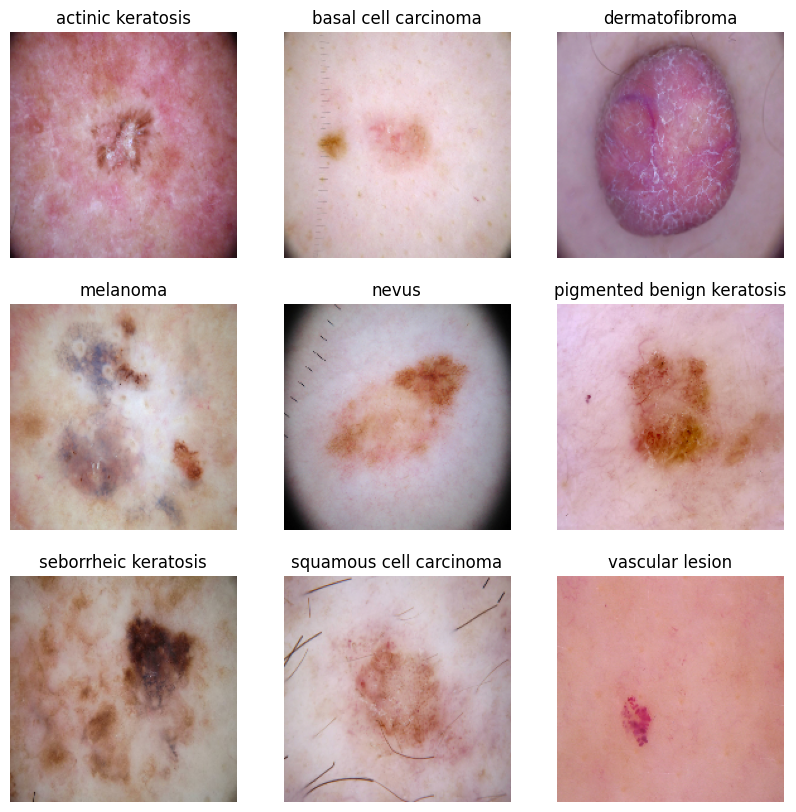

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
def load_images(dataset):
  class_names = dataset.class_names
  plt.figure(figsize=(10, 10))
  for i in range(len(class_names)):
      filtered_ds = dataset.filter(lambda x, l: tf.math.equal(l[0], i))
      print(filtered_ds)
      for image, label in filtered_ds.take(1):
          ax = plt.subplot(3, 3, i+1)
          plt.imshow(image[0].numpy().astype('uint8'))
          plt.title(class_names[label.numpy()[0]])
          plt.axis('off')

load_images(train_ds)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
### Your code goes here
def rescaling_image(dataset):
  normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
  normalized_ds = dataset.map(lambda x, y: (normalization_layer(x), y))

  return normalized_ds

# Notice the pixel values are now in `[0,1]`.
normalized_train_ds = rescaling_image(train_ds)
normalized_val_ds = rescaling_image(val_ds)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
normalized_train_ds = normalized_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function

In [ ]:
def count_by_class(class_names,dataset):
  class_count = {class_name: 0 for class_name in class_names}

  for _, labels in dataset:
      for label in labels.numpy():
          class_name = class_names[label]
          class_count[class_name] += 1
  return class_count

def get_shape(dataset):
   ds = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
   element_spec = ds.element_spec
   return element_spec[0].shape

def get_optimizer(dataset):
  STEPS_PER_EPOCH = img_height / batch_size
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps= STEPS_PER_EPOCH *10,
    decay_rate=1,
    staircase=False)
  print(lr_schedule)
  return tf.keras.optimizers.Adam(lr_schedule)

def build_model(_layers, dataset):
  model = tf.keras.Sequential(_layers)

  model.compile(
     optimizer= get_optimizer(dataset),
     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

  model.build(input_shape= get_shape(dataset))

  return model

def plot_history(model_name, _history,_epochs):
  plt.figure(figsize=(8, 5))

  acc = _history.history['accuracy']
  val_acc = _history.history['val_accuracy']
  loss = _history.history['loss']
  val_loss = _history.history['val_loss']

  acc_std_dev = statistics.pstdev(acc)
  loss_std_dev = statistics.pstdev(loss)

  acc_min = min([min(acc),min(val_acc)])-acc_std_dev
  acc_max = max([max(acc),max(val_acc)])+acc_std_dev

  loss_min = min([min(loss),min(val_loss)])-loss_std_dev
  loss_max = max([max(loss),max(val_loss)])+loss_std_dev

  acc_range = [acc_min,acc_max]
  loss_range = [loss_min, loss_max]

  plt.subplot(1, 2, 1)
  plotter = tfdocs.plots.HistoryPlotter(metric='accuracy')
  plotter.plot({model_name:_history})
  plt.ylim(acc_range)

  plt.subplot(1, 2, 2)
  plotter = tfdocs.plots.HistoryPlotter(metric='loss')
  plotter.plot({model_name:_history})
  plt.ylim(loss_range)

def build_observe(_layers,train_dataset, val_dataset, _epochs, model_name='base'):
    model = build_model(_layers=_layers, dataset=train_dataset)

    print(model.summary())

    _history = model.fit(train_dataset, validation_data=val_dataset, epochs=_epochs)

    plot_history(model_name,_history,_epochs)

    return model,_history


In [ ]:
EPOCHS = 20

In [ ]:
layer = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names))
    ]
model = build_model(
    _layers = layer
    ,dataset = normalized_train_ds
)

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 97200)             0         
                                                                 
 dense (Dense)               (None, 9)                 874809    
                                                                 
Total params: 874809 (3.34 MB)
Trainable params: 874809 (3.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train the model

In [ ]:
_history = model.fit(normalized_train_ds, validation_data=normalized_val_ds, epochs=EPOCHS)

Epoch 1/20
56/56 [==============================] - 262s 4s/step - loss: 35.8127 - accuracy: 0.1724 - val_loss: 9.5405 - val_accuracy: 0.2595
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 4.6534 - accuracy: 0.2846 - val_loss: 3.8734 - val_accuracy: 0.3400
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 2.5092 - accuracy: 0.3583 - val_loss: 2.0334 - val_accuracy: 0.4094
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 2.1039 - accuracy: 0.3817 - val_loss: 1.7068 - val_accuracy: 0.4183
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 2.0949 - accuracy: 0.3783 - val_loss: 2.4880 - val_accuracy: 0.2819
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.8375 - accuracy: 0.4029 - val_loss: 2.0530 - val_accuracy: 0.4116
Epoch 7/20
56/56 [==============================] - 1s 19ms/step - loss: 1.6786 - accuracy: 0.4286 - val_loss: 1.8390 - val_accuracy: 0.3803
Epoch 8/20
5

### Visualizing training results

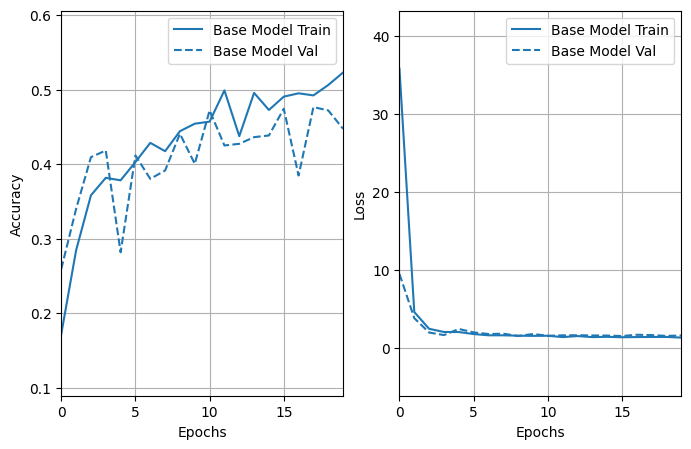

In [ ]:
plot_history('Base Model',_history,EPOCHS)


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

The line between accuracy and val seems consistent and so does the gap. The gap indicates overfitting. Data augmentation will be used to reduce the overfitting

In [ ]:
model_repo = []
model_repo.append({'model_name': 'base' ,'layer': layer,'model': model, 'history':_history, 'epoch': EPOCHS})

### Todo:
### Create the model, compile and train the model


In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Epoch 1/20
56/56 [==============================] - 14s 242ms/step - loss: 38.5076 - accuracy: 0.1652 - val_loss: 6.3064 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 13s 225ms/step - loss: 4.7141 - accuracy: 0.2567 - val_loss: 2.5776 - val_accuracy: 0.3110
Epoch 3/20
56/56 [==============================] - 13s 241ms/step - loss: 2.6133 - accuracy: 0.3315 - val_loss: 1.7988 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 12s 207ms/step - loss: 2.1630 - accuracy: 0.3465 - val_loss: 2.2184 - val_accuracy: 0.3803
Epoch 5/20
56/56 [==============================] - 14s 241ms/step - loss: 1.9495 - accuracy: 0.3772 - val_loss: 2.2026 - val_accuracy: 0.3400
Epoch 6/20
56/56 [==============================] - 14s 260ms/step - loss: 2.0350 - accuracy: 0.3577 - val_loss: 1.8250 - val_accuracy: 0.3423
Epoch 7/20
56/56 [==============================] - 12s 219ms/step - loss: 1.9565 - accuracy: 0.3577 - val_loss: 1.8043 - val_accuracy: 0.429

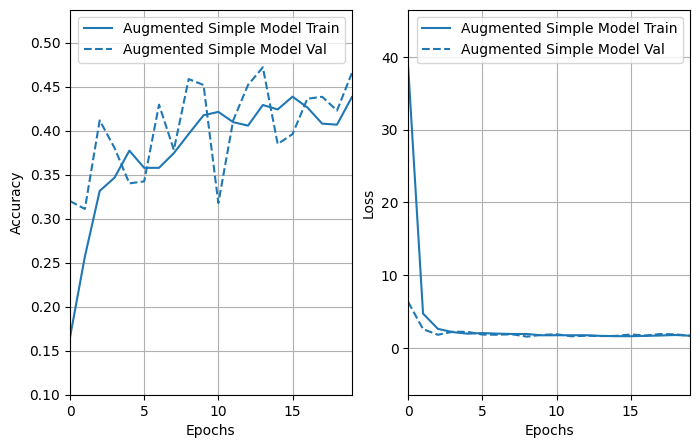

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
layer= [
    data_augmentation,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names))
  ]
model = build_model(
    _layers = layer
    ,dataset = normalized_train_ds
)
_history = model.fit(normalized_train_ds, validation_data=normalized_val_ds, epochs=EPOCHS)
plot_history('Augmented Simple Model',_history,EPOCHS)

model_repo.append({'model_name': 'base with augmentation' ,'layer': layer,'model': model, 'history':_history, 'epoch': EPOCHS})

Training curve overlaps validation curve suggest that overfitting was successfully removed. Training loss and validation loss are moving in similar pattern and overlap each other.

By adding Data Augmentation in the model, the gap between train dataset and val dataset accuracy has reduced significantly. This indicates that the model is no longer overfit as what was seen earlier.

### Compiling the model

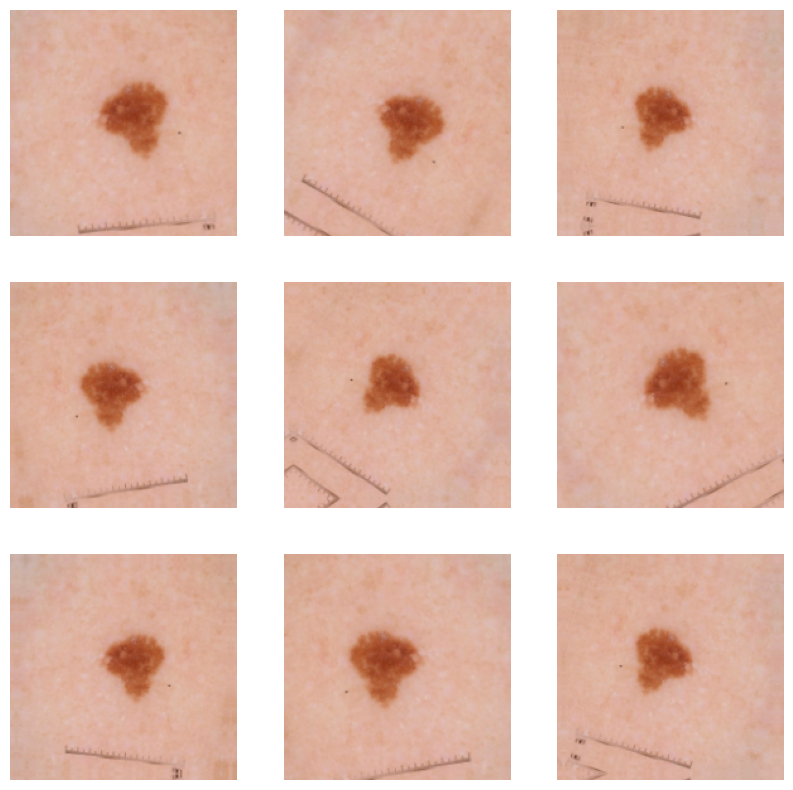

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Training the model

Epoch 1/20
56/56 [==============================] - 56s 977ms/step - loss: 34.7620 - accuracy: 0.2104 - val_loss: 1.9483 - val_accuracy: 0.3043
Epoch 2/20
56/56 [==============================] - 54s 965ms/step - loss: 1.6973 - accuracy: 0.3917 - val_loss: 1.5865 - val_accuracy: 0.4631
Epoch 3/20
56/56 [==============================] - 55s 983ms/step - loss: 1.5324 - accuracy: 0.4537 - val_loss: 1.5377 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 56s 991ms/step - loss: 1.4645 - accuracy: 0.4866 - val_loss: 1.4865 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 54s 961ms/step - loss: 1.3795 - accuracy: 0.5190 - val_loss: 1.4545 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 57s 1s/step - loss: 1.3581 - accuracy: 0.5374 - val_loss: 1.4154 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 64s 1s/step - loss: 1.3029 - accuracy: 0.5463 - val_loss: 1.3775 - val_accuracy: 0.5302
Epoc

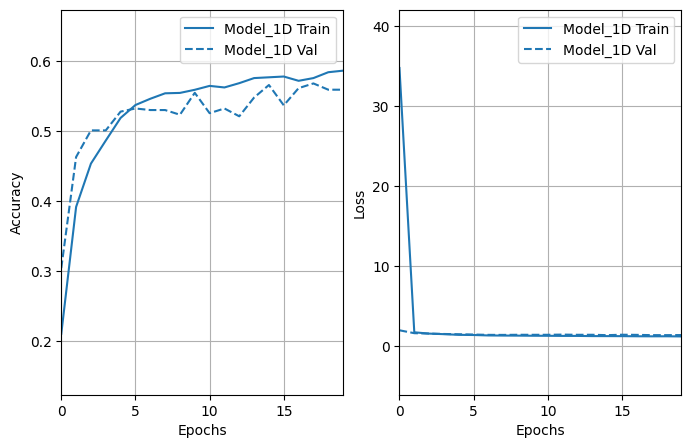

In [ ]:
## Your code goes here
layer= [
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names))
  ]
model = build_model(
    _layers = layer
    ,dataset = normalized_train_ds
)
_history = model.fit(normalized_train_ds, validation_data=normalized_val_ds, epochs=EPOCHS)
plot_history('model_1D',_history,EPOCHS)

model_repo.append({'model_name': 'model_1D' ,'layer': layer,'model': model, 'history':_history, 'epoch': EPOCHS})

In [ ]:
layer= [
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names))
  ]
model = build_model(
    _layers = layer
    ,dataset = normalized_train_ds
)
_history = model.fit(normalized_train_ds, validation_data=normalized_val_ds, epochs=EPOCHS)
plot_history('model_1D',_history,EPOCHS)

model_repo.append({'model_name': 'model_22D_1M' ,'layer': layer,'model': model, 'history':_history, 'epoch': EPOCHS})

Epoch 1/20
56/56 [==============================] - 275s 5s/step - loss: 2.4611 - accuracy: 0.3231 - val_loss: 1.5971 - val_accuracy: 0.4810
Epoch 2/20
56/56 [==============================] - 270s 5s/step - loss: 1.5138 - accuracy: 0.4648 - val_loss: 1.4851 - val_accuracy: 0.4877
Epoch 3/20
56/56 [==============================] - 268s 5s/step - loss: 1.3942 - accuracy: 0.5162 - val_loss: 1.3971 - val_accuracy: 0.5436
Epoch 4/20
56/56 [==============================] - 269s 5s/step - loss: 1.3329 - accuracy: 0.5285 - val_loss: 1.3906 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 265s 5s/step - loss: 1.2833 - accuracy: 0.5402 - val_loss: 1.4131 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 270s 5s/step - loss: 1.2559 - accuracy: 0.5530 - val_loss: 1.3954 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 263s 5s/step - loss: 1.2443 - accuracy: 0.5670 - val_loss: 1.4036 - val_accuracy: 0.5414
Epoch 8/20
56

In [ ]:
model_plans = {
   'base_model': [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names))
    ]
   ,'model_1D': [
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(len(class_names))
   ]
   ,'model_2D_1M': [
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(len(class_names))
   ]
   ,'model_2D_2M': [
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(len(class_names))
   ]

}


In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = ## your training code

### Visualizing the results

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#####Distribution for Train dataset

<Axes: xlabel='Class'>

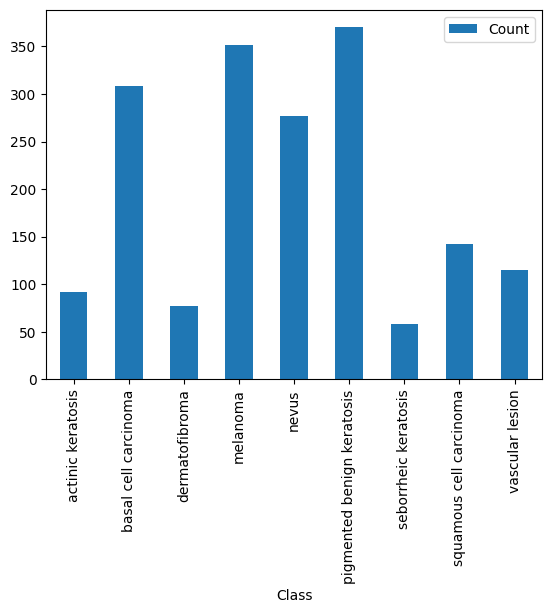

In [ ]:
cnt= count_by_class(class_names, train_ds)
df = pd.DataFrame(list(cnt.items()), columns=['Class', 'Count'])
df.plot.bar(x='Class')

#####Distribution for Valuation dataset

<Axes: xlabel='Class'>

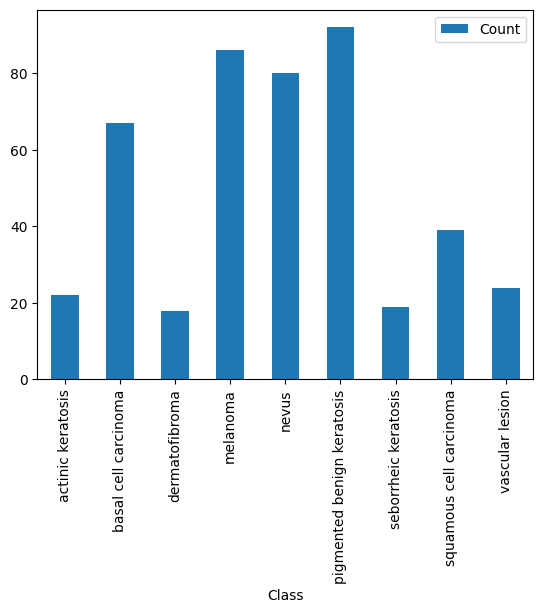

In [ ]:
cnt= count_by_class(class_names, val_ds)
df = pd.DataFrame(list(cnt.items()), columns=['Class', 'Count'])
df.plot.bar(x='Class')

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

#### **Todo:** Create a training dataset

#### **Todo:** Create a validation dataset

#### **Todo:** Create your model (make sure to include normalization)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

